In [3]:
#Data manipulation
import pandas as pd
import numpy as np

#Image handling
from PIL import Image
import matplotlib.pyplot as plt

#Handling path
import time

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

#Pythorch for datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

#Pytorch for data augmentation
from torchvision.transforms import v2
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Flood Segmentation/metadata.csv')

In [3]:
df['Image'] = [os.path.join('/content/drive/MyDrive/Flood Segmentation/Image', i) for i in df['Image']]
df['Mask'] = [os.path.join('/content/drive/MyDrive/Flood Segmentation/Mask', i) for i in df['Mask']]
df.head()

,Image,Mask
0,/content/drive/MyDrive/Flood Segmentation/Imag...,/content/drive/MyDrive/Flood Segmentation/Mask...
1,/content/drive/MyDrive/Flood Segmentation/Imag...,/content/drive/MyDrive/Flood Segmentation/Mask...
2,/content/drive/MyDrive/Flood Segmentation/Imag...,/content/drive/MyDrive/Flood Segmentation/Mask...
3,/content/drive/MyDrive/Flood Segmentation/Imag...,/content/drive/MyDrive/Flood Segmentation/Mask...
4,/content/drive/MyDrive/Flood Segmentation/Imag...,/content/drive/MyDrive/Flood Segmentation/Mask...


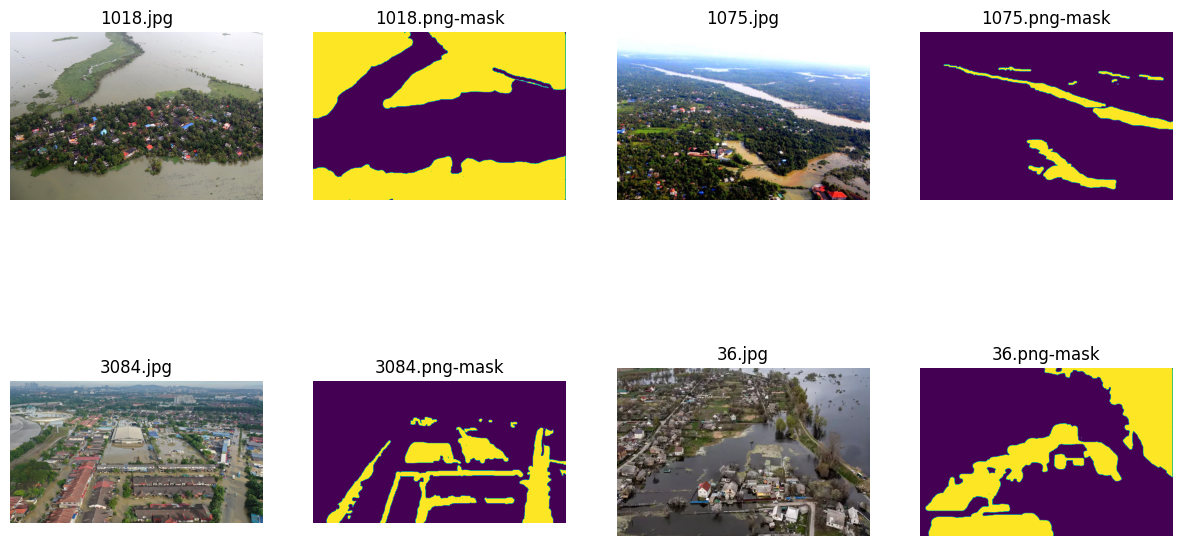

In [4]:
show_imgs = 4  # how many images will be displayed
idx = np.random.choice(len(df), show_imgs, replace=False) # takes random indices of show_imgs from dataframe
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8)) # creates a figure with subplots based on the number of images
axes = axes.flatten() # flatten 2D into 1D
for i, ax in enumerate(axes):
  new_i = i//2
  if i % 2 == 0: # image subplot if even
    full_path = df.loc[idx[new_i]]['Image']
    basename = os.path.basename(full_path)
  else: # mask sunplot if odd
    full_path = df.loc[idx[new_i]]['Mask']
    basename = os.path.basename(full_path) + '-mask'
  ax.imshow(plt.imread(full_path)) # Loads and displays the image or mask in the subplot.
  ax.set_title(basename)
  ax.set_axis_off() # turns off the axes to sublot only the mask and image

#Create datasets and dataloads

In [5]:
train_transforms = A.Compose([ # Augmentation technique from albumentations library
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04, 0.04), rotate_limit=(-15, 15), p=0.5),

    ], is_check_shapes = False
)

test_transforms = A.Compose([
    A.Resize(512, 512),
    ], is_check_shapes = False
)

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, transforms_=None):
    self.df = dataframe # stores an initial df

    # we will use transforms for data augmentation and converting PIL images to torch tensors
    self.transforms_ = transforms_  #stores transfromed df
    self.pre_normalize = v2.Compose([
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    self.resize = [512, 512]
    self.class_size = 2

  def __len__(self):
      return len(self.df)

  def __getitem__(self, index):
      img = np.array(Image.open(self.df.iloc[index]['Image']).convert('RGB'))
      mask = np.array(Image.open(self.df.iloc[index]['Mask']).convert('L'))

      mask = np.where(mask<127, 0, 1).astype(np.int16)
      aug = self.transforms_(image=img, mask=mask)
      img, mask = aug['image'], aug['mask']
      img = img/255
      img = self.pre_normalize(img)
      img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
      target = torch.tensor(mask, dtype = torch.long)
      sample = {'x':img, 'y':target}
      return sample




In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=9898)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')


len train: 232
len val: 58


#Create a model

In [7]:
class_size = 1
model = smp.Unet(
    encoder_name = "resnet50",
    encoder_weights="imagenet",
    in_channels = 3,
    classes=class_size,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model(torch.randn((1, 3, 512, 512)))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 276MB/s]


tensor([[[[-0.3078, -0.2090,  0.3322,  ..., -0.7501, -0.2095, -0.3684],
          [-0.4997, -0.7779, -0.4297,  ..., -0.3820, -0.0871, -0.2017],
          [-0.9360, -0.2168,  0.0148,  ..., -0.1563, -0.3593,  0.3498],
          ...,
          [-0.1472,  0.6176, -0.3327,  ..., -0.3994, -0.6417, -0.7038],
          [-0.1835, -0.3156, -0.6281,  ...,  0.1101, -0.1018,  0.2663],
          [-0.3126,  0.0856, -0.3423,  ...,  0.1081, -0.2565,  0.4571]]]],
       grad_fn=<ConvolutionBackward0>)

#Training and testing

In [8]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
  size = len(dataloader.dataset) #number of samples
  num_batches = len(dataloader)
  model.train()
  epoch_loss = 0
  epoch_iou_score = 0
  for batch_i, batch in enumerate(dataloader):
    x, y = batch['x'].to(device), batch['y'].to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y)
    loss.backward() # backpropagation to compute gradients
    optimizer.step()  # update model params

    epoch_loss += loss.item()
    pred = pred.squeeze(dim=1)
    pred = torch.sigmoid(pred)
    y = y.round().long()
    tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode = 'binary', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro").item()
    epoch_iou_score += iou_score
    lr_scheduler.step()

  return epoch_loss/num_batches, epoch_iou_score/num_batches


def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)

  model.eval()
  epoch_loss = 0
  epoch_iou_score = 0
  # no gradient for test data

  with torch.no_grad():
    for batch_i, batch in enumerate(dataloader):
      x, y = batch['x'].to(device), batch['y'].to(device) # move data to gpu

      # compute prediction loss
      pred = model(x)
      loss = loss_fn(pred, y)
      epoch_loss += loss.item()
      pred = pred.squeeze(dim=1)
      pred = torch.sigmoid(pred)
      y = y.round().long()
      tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
      iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro').item()
      epoch_iou_score += iou_score

  return epoch_loss/num_batches, epoch_iou_score/num_batches

In [ ]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss':[],
    'train_iou_score': [], 'val_iou_score': []
}

if os.path.exists('checkpoints') == False:
  os.mkdir('checkpoints')

loss_fn = smp.losses.DiceLoss(mode='binary')

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma = 0.1)

# Early stopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
  val_loss, val_iou_score = test(val_loader, model, loss_fn)
  logs['train_loss'].append(train_loss)
  logs['val_loss'].append(val_loss)
  logs['train_iou_score'].append(train_iou_score)
  logs['val_iou_score'].append(val_iou_score)

  print(f'EPOCH:{str(epoch+1).zfill(3)}) \
  train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
  train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f}\
  lr: {optimizer.param_groups[0]["lr"]}')

  torch.save(model.state_dict(), "checkpoints/last.pth")

  if val_loss < best_loss:
    counter = 0
    best_loss = val_loss
    torch.save(model.state_dict(), "checkpoints/best.pth")
  else:
    counter += 1
  if counter >= patience:
    print("early stopping")
    break

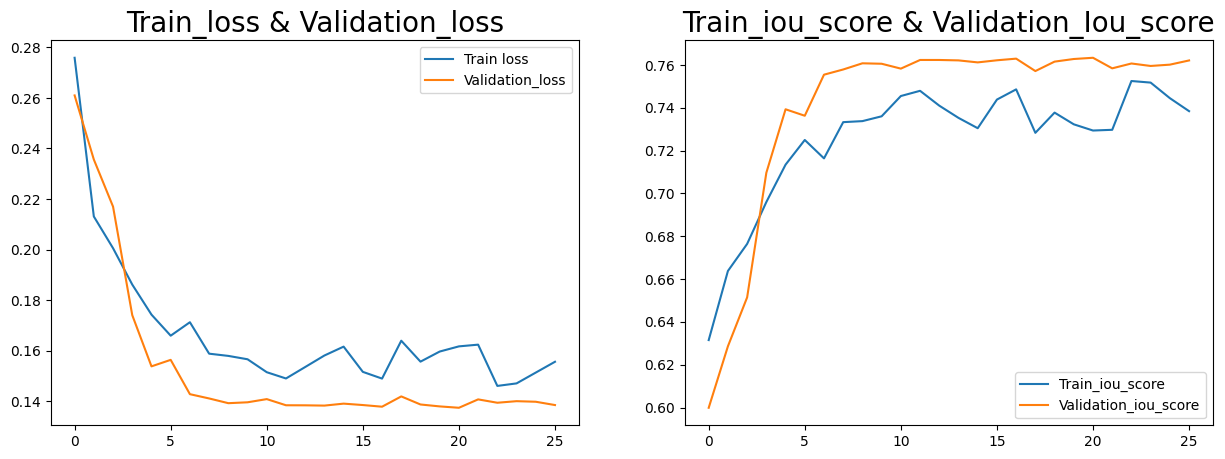

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(logs['train_loss'], label = 'Train loss')
plt.plot(logs['val_loss'], label = 'Validation_loss')
plt.title('Train_loss & Validation_loss', fontsize = 20)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs['train_iou_score'], label = 'Train_iou_score')
plt.plot(logs['val_iou_score'], label = 'Validation_iou_score')
plt.title('Train_iou_score & Validation_Iou_score', fontsize = 20)
plt.legend()

#Metrics

In [ ]:
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, transforms_=None):
    self.df = dataframe
    self.transforms_ = transforms_
    self.pre_normalize = v2.Compose([
        v2.Normalize(mean=[0.485, 0.456, 0.496], std = [0.229, 0.224,0.225]),
    ])
    self.resize = [512, 512]
    self.class_size = 2

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['Image']), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.df.iloc[index]['Mask'], cv2.IMREAD_GRAYSCALE)

    aug = self.transforms_(image=img, mask=mask)
    img, mask = aug['image'], aug['mask']
    img_view = np.copy(img)
    img = img/255
    img = self.pre_normalize(img)
    img = torch.tensor(img, dtype = torch.float).permute(2, 0, 1)
    mask_view = np.copy(mask)
    mask = np.where(mask < 127, 0, 1).astype(np.int16)
    target = torch.tensor(mask, dtype = torch.long)
    sample = {'x': img, 'y': target, 'img_view': img_view, 'mask_view': mask_view}
    return sample

test_dataset = TestDataset(val_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size = 4)






In [ ]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.to(device)
def get_metrics(model, dataloader, threshold):
  IoU_score, precision, f1_score, recall, acc = 0, 0, 0, 0, 0
  batchs = 0
  model.eval()
  with torch.no_grad():
    for batch_i, batch in enumerate(dataloader):
      x, y = batch['x'].to(device), batch['y'].to(device)

      pred = model(x)
      pred = pred.squeeze(dim=1)
      pred = torch.sigmoid(pred)
      y = y.round().long()
      tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode = 'binary', threshold = threshold)
      batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction = 'micro').item()
      batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction = 'micro').item()
      batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction = 'micro').item()
      batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction = 'micro').item()
      batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction = 'micro').item()

      IoU_score += batch_iou_score
      acc += batch_acc
      f1_score += batch_f1_score
      recall += batch_recall
      precision += batch_precision
      batchs += 1

  IoU_score = round(IoU_score/batchs, 3)
  precision = round(precision/batchs, 3)
  f1_score = round(f1_score/batchs, 3)
  recall = round(recall/batchs, 3)
  acc = round(acc/batchs, 3)
  sample = {'iou': IoU_score, 'pre': precision, 'f1': f1_score, 're': recall, 'acc': acc}
  return sample

threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
  sample = get_metrics(model, test_loader, threshold)
  print(f"threshold: {str(threshold)} \
        IoU Score: {sample['iou']:.3f} \
        precision: {sample['pre']:.3f} \
        f1_score: {sample['f1']:.3f} \
        Recall: {sample['re']:.3f} \
        Acc: {sample['acc']:.3f} ")

threshold: 0.3         IoU Score: 0.764         precision: 0.870         f1_score: 0.865         Recall: 0.866         Acc: 0.898 
threshold: 0.4         IoU Score: 0.764         precision: 0.872         f1_score: 0.864         Recall: 0.864         Acc: 0.898 
threshold: 0.5         IoU Score: 0.763         precision: 0.874         f1_score: 0.864         Recall: 0.862         Acc: 0.898 
threshold: 0.6         IoU Score: 0.763         precision: 0.876         f1_score: 0.864         Recall: 0.860         Acc: 0.898 
threshold: 0.7         IoU Score: 0.763         precision: 0.878         f1_score: 0.864         Recall: 0.858         Acc: 0.898 


#Inference

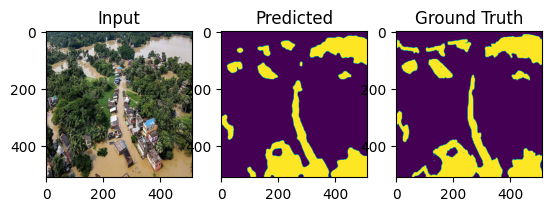

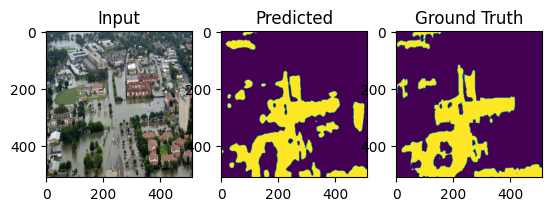

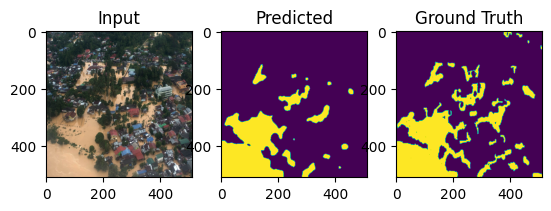

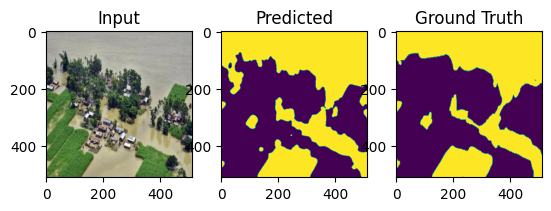

In [ ]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace = False)

for i in range(show_imgs):
  idx = random_list[i]
  sample = test_dataset[idx]
  pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
  pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
  pred = pred.data.cpu().numpy()
  pred = np.where(pred<0.5, 0, 1).astype(np.int16)
  pred_img = Image.fromarray(np.uint8(pred), 'L')

  img_view = sample['img_view']
  img_view = Image.fromarray(img_view, 'RGB')

  mask_view = sample['mask_view']
  mask_view = Image.fromarray(mask_view, 'L')

  f, axarr = plt.subplots(1, 3)
  axarr[0].imshow(img_view)
  axarr[0].set_title('Input')
  axarr[1].imshow(pred_img)
  axarr[1].set_title('Predicted')
  axarr[2].imshow(mask_view)
  axarr[2].set_title('Ground Truth')
  plt.show()




In [ ]:
from torchvision.transforms import ToTensor, Resize
from PIL import Image

#Loading images from a local PC for testing

In [ ]:
def load_image_from_pc(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        resize_transform = Resize((576, 1024))  # Resize to the nearest divisible-by-32 dimensions
        image = resize_transform(image)
        return ToTensor()(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    except Exception as e:
        print(f"Error loading the image: {e}")
        return None

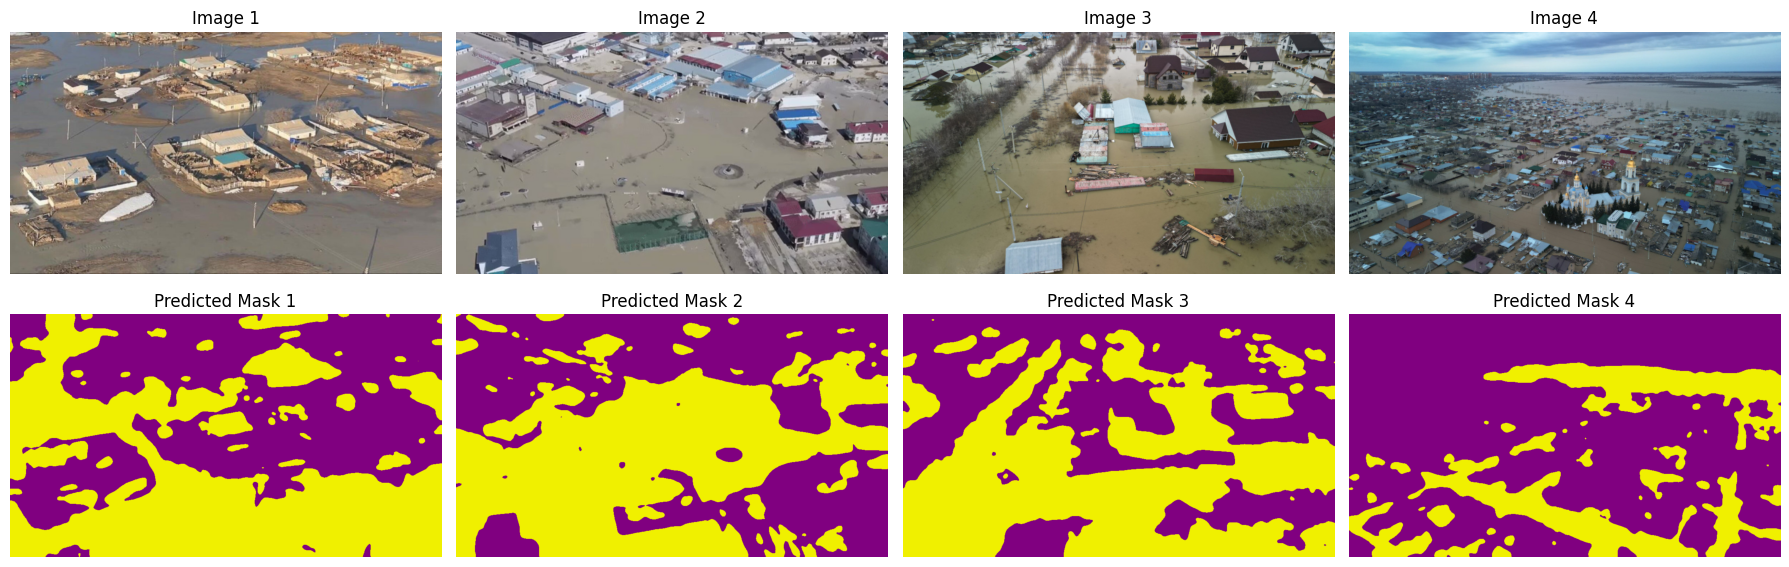

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming segmentation_masks contains your predicted segmentation masks
# You can modify the colors as needed
def visualize_segmentation_with_custom_colors(images, segmentation_masks):
    colors = [(128, 0, 128), (240, 240, 0)]  # Purple and Yellow colors (RGB format)

    plt.figure(figsize=(18, 6))

    for i in range(len(images)):
        # Subplot for original image
        plt.subplot(2, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i + 1}')
        plt.axis('off')

        # Subplot for predicted mask with custom colors
        masked_image = np.zeros_like(images[i])
        for j, color in enumerate(colors):
            masked_image[segmentation_masks[i] == j] = color

        plt.subplot(2, len(images), i + 1 + len(images))
        plt.imshow(masked_image)
        plt.title(f'Predicted Mask {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage example:
# Assuming images and segmentation_masks are your list of images and predicted masks
visualize_segmentation_with_custom_colors(images, segmentation_masks)


In [ ]:
# Assuming scale information (e.g., meters per pixel)
scale = 0.028  # Example scale: 0.028 meters per pixel

# Calculate the area of a single pixel
pixel_area = scale ** 2  # Square meters

# Calculate the total water area in the image
water_pixels = (segmentation_mask > 0).sum()  # Count water pixels
water_area = water_pixels * pixel_area  # Total water area in square meters

print(water_area, "square meters")

#Prediction of the Flood on the Meteorological data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Flood Segmentation/kerala.csv')

In [5]:
data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,YES
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,YES
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,YES
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,YES
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,NO


In [6]:
#Check for empty columns
data.apply(lambda x:sum(x.isnull()), axis=0)

SUBDIVISION         0
YEAR                0
JAN                 0
FEB                 0
MAR                 0
APR                 0
MAY                 0
JUN                 0
JUL                 0
AUG                 0
SEP                 0
OCT                 0
NOV                 0
DEC                 0
 ANNUAL RAINFALL    0
FLOODS              0
dtype: int64

In [7]:
#Change YES/NO into binary 0/1
data['FLOODS'].replace(['YES', 'NO'], [1, 0], inplace=True)

In [8]:
data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,1
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,1
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,1
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,1
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,0


In [9]:
#Separate the data we are going to use for prediction
x = data.iloc[:, 1:14]
x.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4
1,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5
2,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0
3,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3
4,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2


In [10]:
#Separate the FLOOD column
y = data.iloc[:, -1]
y.head()

0    1
1    1
2    1
3    1
4    0
Name: FLOODS, dtype: int64

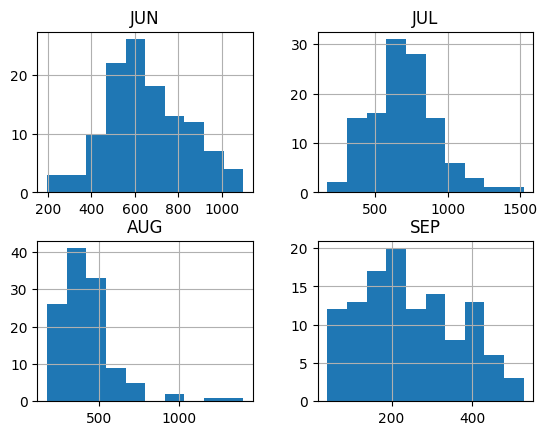

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
c = data[['JUN', 'JUL', 'AUG', 'SEP']]
c.hist()
plt.show()

In [12]:
#Rescale the data between 0 and 1 for easier processing
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
minmax.fit(x).transform(x)

array([[0.        , 0.34371257, 0.56582278, ..., 0.39727673, 0.95570189,
        0.2388724 ],
       [0.00854701, 0.08023952, 0.03291139, ..., 0.5804966 , 0.37952709,
        0.60039565],
       [0.01709402, 0.03832335, 0.23544304, ..., 0.57188626, 0.37563604,
        0.29129575],
       ...,
       [0.98290598, 0.02874251, 0.04810127, ..., 0.31517821, 0.28105358,
        0.11622156],
       [0.99145299, 0.02275449, 0.08607595, ..., 0.24809772, 0.18258007,
        0.18793274],
       [1.        , 0.34850299, 0.65949367, ..., 0.57589107, 0.28105358,
        0.3214639 ]])

#Split into train and test dataset 80% train : 20% test

In [13]:
from sklearn import model_selection, neighbors
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [14]:
x_train.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
62,1963,30.2,24.8,69.8,96.3,157.1,393.3,720.2,511.0,223.9,282.6,93.4,48.4
33,1934,74.5,1.7,47.7,92.4,106.7,852.9,415.0,337.2,48.4,335.9,93.4,4.9
30,1931,3.3,0.3,19.2,126.9,131.7,541.7,653.9,1199.2,163.2,149.3,164.3,106.5
74,1975,5.2,21.4,63.4,123.8,162.2,864.4,531.3,675.9,457.7,368.9,204.3,19.9
18,1919,43.0,6.1,33.9,65.9,247.0,636.8,648.0,484.2,255.9,249.2,280.1,53.0


In [15]:
y_train.head()

62    0
33    0
30    1
74    1
18    1
Name: FLOODS, dtype: int64

#Logistic Regression Model for binary prediction

In [16]:
x_train_std = minmax.fit_transform(x_train)
x_test_std = minmax.fit_transform(x_test)

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [18]:
lr = LogisticRegression()
lr_clf = lr.fit(x_train_std, y_train)

lr_accuracy = cross_val_score(lr_clf, x_test_std, y_test, cv=3, scoring='accuracy', n_jobs=-1)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [19]:
lr_accuracy.mean()

0.75

In [20]:
y_predict = lr_clf.predict(x_test_std)
print('Predicted chances of flood:', y_predict)

print('Actual chances of flood:   ', y_test.values)

Predicted chances of flood: [1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1]
Actual chances of flood:    [1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0]


In [21]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
print("\naccuracy score: %.2f"%(accuracy_score(y_test, y_predict)*100))
print("recall score: %.2f"%(accuracy_score(y_test, y_predict)*100))
print("roc score: %.2f"%(accuracy_score(y_test, y_predict)*100))


accuracy score: 83.33
recall score: 83.33
roc score: 83.33
